## Clasificacion de tweets según sentimiento con Bag-of-words,

**CAIRO Lucia** **13030**

El objetivo es construir un modelo de clasificación de sentimientos usando el método Bag-of-Words (BoW) en un dataset de tweets llamado Sentiment140. Este dataset contiene 1.6 millones de tweets que han sido etiquetados como positivos (4) o negativos (0).

#### Descripción del Dataset

El dataset utilizado proviene de Kaggle y contiene tweets etiquetados como positivos (4) o negativos (0).

Dataset disponible en: https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

#### Objetivo del Análisis

El objetivo es construir un modelo que aprende de los datos etiquetados para predecir si un tweet nuevo expresa un sentimiento positivo o negativo

1. **Importar las bibliotecas necesarias**
2. **Cargar el dataset**
3. **Explorar y limpiar los datos**
4. **Preparar los datos**
5. **Dividir los datos**
6. **Método Bag-of-Words (BoW)**
7. **Definir el modelo**
8. **Entrenar el modelo**
9. **Evaluar el modelo**

### 1. Importar las bibliotecas necesarias

In [58]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
import string
import re



### 2. Cargar el dataset



In [60]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('./Texto/archive/training.1600000.processed.noemoticon.csv', encoding='latin-1', names=columns)

# evitar problemas de memoria
df = df[['target', 'text']].sample(frac=0.02, random_state=1)
df.head(5)

,target,text
514293,0,i miss nikki nu nu already shes always there ...
142282,0,So I had a dream last night. I remember a sig...
403727,0,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,0,it is raining again
610789,0,@MissKeriBaby wish I was in LA right now


### 3. Explorar y limpiar los datos


In [61]:
df.info()
df.describe()

df = df[['target', 'text']] # columnas que nos interesan

df['target'] = df['target'].replace({0: 'negativo', 4: 'positivo'})
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 32000 entries, 514293 to 1041000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  32000 non-null  int64 
 1   text    32000 non-null  object
dtypes: int64(1), object(1)
memory usage: 750.0+ KB


,target,text
514293,negativo,i miss nikki nu nu already shes always there ...
142282,negativo,So I had a dream last night. I remember a sig...
403727,negativo,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,negativo,it is raining again
610789,negativo,@MissKeriBaby wish I was in LA right now


### 4. Preparar los datos

In [62]:
# convertir a minúsculas y eliminar puntuación
def custom_standardization(text):
    lowercase_text = text.lower()
    return re.sub(f'[{re.escape(string.punctuation)}]', '', lowercase_text)

df['text'] = df['text'].apply(custom_standardization)

# Mostrar el resultado
df.head()


,target,text
514293,negativo,i miss nikki nu nu already shes always there ...
142282,negativo,so i had a dream last night i remember a sign...
403727,negativo,girlyghost ohh poor sickly you hugs hope you...
649503,negativo,it is raining again
610789,negativo,misskeribaby wish i was in la right now


**Visualizaciones previas**

*Distribución de sentimientos*

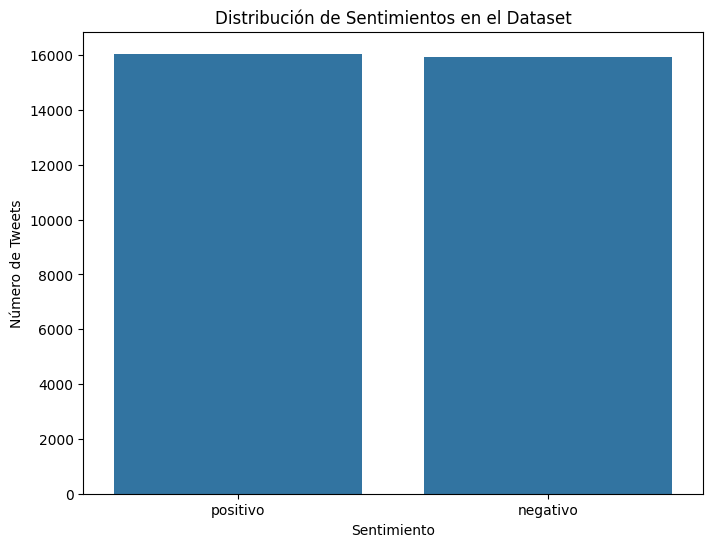

In [63]:
sentiment_counts = df['target'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribución de Sentimientos en el Dataset')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Tweets')
plt.show()

**Palabras más frecuentes en tweets**

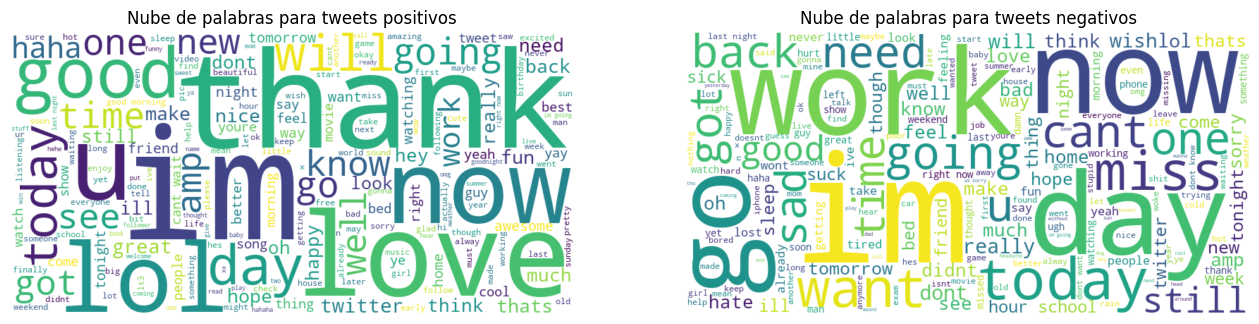

C:\Users\Luci\AppData\Local\Temp\ipykernel_444\3676807711.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['target'] = df['target'].replace({'negativo': 0 , 'positivo':4})


In [71]:
from collections import Counter

positive_tweets = df[df['target'] == 'positivo']['text'].str.cat(sep=' ')
negative_tweets = df[df['target'] == 'negativo']['text'].str.cat(sep=' ')

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Nube de palabras para tweets positivos')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Nube de palabras para tweets negativos')
plt.axis('off')

plt.show()

df['target'] = df['target'].replace({'negativo': 0 , 'positivo':4})
df['target'] = df['target'].replace(4, 1)

### 5. Dividir los datos 

In [72]:
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Convertimos los datos a tensores
train_texts = train_df['text'].values
train_labels = train_df['target'].values
test_texts = test_df['text'].values
test_labels = test_df['target'].values

### 6. Método Bag-of-Words (BoW)

In [73]:
# Paso 3: Vectorización usando Bag-of-Words
# Creamos una capa TextVectorization que tokeniza y convierte el texto a representaciones de bag-of-words
max_tokens = 2000  # Tamaño máximo del vocabulario
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode='multi_hot'  # Bag-of-Words
)

# Adaptamos el vectorizador al conjunto de entrenamiento
text_vectorization.adapt(train_texts)

# Vectorizamos el conjunto de entrenamiento y prueba
train_texts_vectorized = text_vectorization(train_texts)
test_texts_vectorized = text_vectorization(test_texts)


### 7. Definir el modelo

In [74]:

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)  # Sigmoid para clasificación binaria
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

# Crear el modelo
model = get_model(max_tokens=max_tokens)
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │        32,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,033 (125.13 KB)

 Trainable params: 32,033 (125.13 KB)

 Non-trainable params: 0 (0.00 B)

### 8. Entrenar el modelo

In [75]:
batch_size = 32
epochs = 10

model.fit(
    train_texts_vectorized, train_labels,
    validation_data=(test_texts_vectorized, test_labels),
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6161 - loss: 0.6556 - val_accuracy: 0.7295 - val_loss: 0.5579
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7352 - loss: 0.5515 - val_accuracy: 0.7419 - val_loss: 0.5327
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7510 - loss: 0.5324 - val_accuracy: 0.7425 - val_loss: 0.5282
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7541 - loss: 0.5201 - val_accuracy: 0.7455 - val_loss: 0.5288
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7621 - loss: 0.5140 - val_accuracy: 0.7466 - val_loss: 0.5294
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7692 - loss: 0.5068 - val_accuracy: 0.7473 - val_loss: 0.5311
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7612 - loss: 0.5117 - val_accuracy: 0.7437 - val_loss: 0.5310
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7716 - loss: 0.4963 - val_accuracy: 0.

### 8. Evaluar el modelo

In [76]:
# Paso 6: Evaluación del modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_texts_vectorized, test_labels)
print(f"Loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")



200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7471 - loss: 0.5313
Loss: 0.533
Test accuracy: 0.747


### 9. Interpretacion 

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


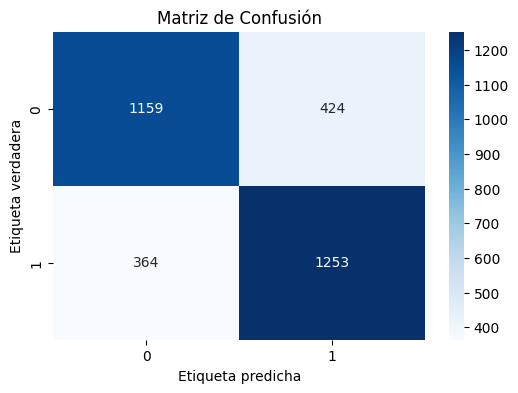

In [33]:
from sklearn.metrics import confusion_matrix
#y_pred = model.predict(X_test)
predictions = model.predict(test_texts_vectorized)
y_pred = (predictions > 0.5).astype("int32")
y_test = test_labels

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Visualizar la matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de Confusión')
plt.show()

**True Positives (TP)**: 2 clientes compraron y fueron clasificados correctamente como compradores

**False Positives (FP)**: 2 clientes no compraron pero fueron clasificados incorrectamente como compradores

**False Negatives (FN)**: 1 cliente compro pero fue clasificados incorrectamente como no comprador

**True Negatives (TN)**: 1 cliente no compro y fue clasificados correctamente como no comprador

 Matriz de Confusión Normalizada
Además de la matriz de confusión básica, puedes crear una matriz de confusión normalizada para visualizar mejor la proporción de predicciones correctas e incorrectas.

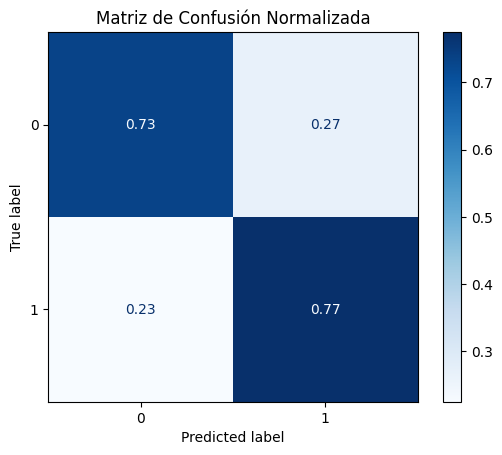

In [83]:
# Matriz de confusión normalizada
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Visualizar la matriz de confusión normalizada
disp_normalized = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=[0, 1])
disp_normalized.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión Normalizada")
plt.show()

In [77]:
# Informe de clasificación
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.76      0.73      0.75      1583
           1       0.75      0.77      0.76      1617

    accuracy                           0.75      3200
   macro avg       0.75      0.75      0.75      3200
weighted avg       0.75      0.75      0.75      3200



**Clase que NO compró:**
   - **Precision (Precisión)**: El 67% de los clientes clasificados como "no compradores" realmente no compraron.
   - **Recall (Sensibilidad)**: El 50% de los clientes que realmente no compraron fueron correctamente identificados.
   - **Support**: 4  verdaderos casos de la clase que no compro en el conjunto de datos.

**Clase que SI compró:**
   - **Precision (Precisión)**: El 33% de los clientes clasificados como "compradores" realmente compraron.
   - **Recall (Sensibilidad)**: El 50% de los clientes que realmente compraron fueron correctamente identificados.
   - **Support**: 2 verdaderos casos de la clase 1 en el conjunto de datos.

**Accuracy (Precisión Global)**: El modelo clasifica correctamente el 50% de los casos totales.

*La mitad de las predicciones fueron correctas. El modelo tiene un mejor desempeño en la identificación de clientes que no compraron.*


La curva ROC (Receiver Operating Characteristic) muestra la relación entre la tasa de verdaderos positivos (TPR) y la tasa de falsos positivos (FPR) en diferentes umbrales. El área bajo la curva (AUC) proporciona una medida única de la capacidad de discriminación del modelo

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


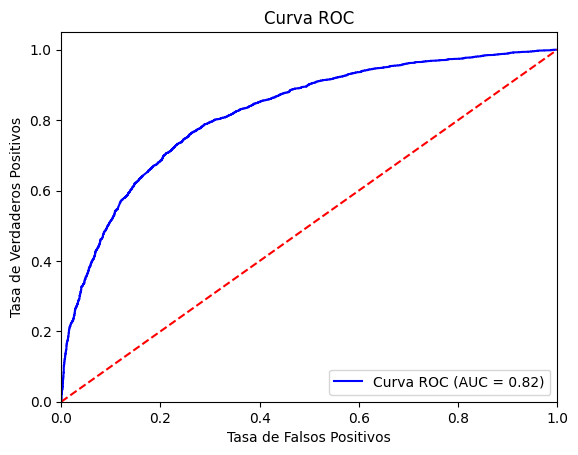

In [84]:
from sklearn.metrics import roc_curve, auc

# Calcular las probabilidades de predicción
probabilities = model.predict(test_texts_vectorized).flatten()
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


 Histogramas de Predicciones
Puedes visualizar la distribución de las predicciones para ver cuántos tweets fueron clasificados como positivos y negativos.

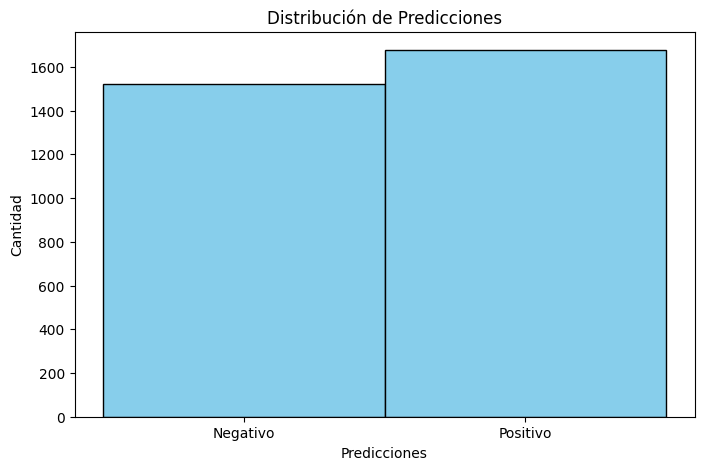

In [85]:
plt.figure(figsize=(8, 5))
plt.hist(predicted_labels, bins=np.arange(-0.5, 2, 1), edgecolor='black', align='mid', color='skyblue')
plt.xticks([0, 1], ['Negativo', 'Positivo'])
plt.xlabel('Predicciones')
plt.ylabel('Cantidad')
plt.title('Distribución de Predicciones')
plt.show()


## TWEET POSITIVO O NEGATIVO??

In [81]:

def predict_sentiment(tweet):
    tweet = custom_standardization(tweet)
    tweet_vectorized = text_vectorization(np.array([tweet]))
    prediction = model.predict(tweet_vectorized)
    sentiment = "positivo" if prediction > 0.5 else "negativo"
    return sentiment

# Ejemplo de uso de la función
invented_tweet = "I love this new product, it's amazing!"
# invented_tweet = "I hate everyone, I'm tired of working. I love to complain"
sentiment = predict_sentiment(invented_tweet)
print(f"El tweet: '{invented_tweet}' es {sentiment}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
El tweet: 'I love this new product, it's amazing!' es positivo.
